<a href="https://colab.research.google.com/github/BirdiD/NLP/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sentiment Analysis with Logistic Regression**

Sentiment Analysis is the process of interpreting and classifying polarity   within a text data. It uses Natural Language Processing & text analysis techniques to determine whether a text expresses a positive, negative or a neutral emotion. It is used by businesses to help them understand the social sentiment of their product or the service they provide. 

##Setup

In [67]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


##Download the data

In [68]:
data = pd.read_csv('Airline-Sentiment-2-w-AA.csv', encoding = "ISO-8859-1")

In [69]:
data.head(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)


Let's get rid of columns we do not need for the sentiment analysis. The only columns to be left are the sentiment one (Positive, Negative or neutral) and the tweets. We will also keep the airline columns just to see the amount of reviews each company gets.

In [70]:
trash = ['_unit_id','_golden', 'airline_sentiment:confidence','_unit_state','_trusted_judgments','_last_judgment_at','negativereason','negativereason:confidence','airline_sentiment_gold','name','negativereason_gold','retweet_count','tweet_coord','tweet_created','tweet_id','tweet_location','user_timezone']
new_data = data.drop(trash, axis=1)

In [71]:
new_data = new_data.reindex(['airline_sentiment', 'text', 'airline'], axis=1)
new_data.columns = ['sentiment', 'tweets', 'airline'] 
new_data

,sentiment,tweets,airline
0,neutral,@VirginAmerica What @dhepburn said.,Virgin America
1,positive,@VirginAmerica plus you've added commercials t...,Virgin America
2,neutral,@VirginAmerica I didn't today... Must mean I n...,Virgin America
3,negative,@VirginAmerica it's really aggressive to blast...,Virgin America
4,negative,@VirginAmerica and it's a really big bad thing...,Virgin America
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,American
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,American
14637,neutral,@AmericanAir Please bring American Airlines to...,American
14638,negative,"@AmericanAir you have my money, you change my ...",American


We will store the tweets as list. Individual tweets are stored as strings

#Data Analysis

In [72]:
new_data.describe()

,sentiment,tweets,airline
count,14640,14640,14640
unique,3,14427,6
top,negative,@united thanks,United
freq,9178,6,3822


In [73]:
from collections import Counter
Counter(new_data['sentiment'])


Counter({'negative': 9178, 'neutral': 3099, 'positive': 2363})

There are free unique sentiments in the dataset (Positive, Negative and Neutral). As you can see above, the dataset is imbalanced. There are far more negative comments than the positive ones. The dataset  reflects the real distributions of positive and negative classes in live Twitter streams. There are 6 different airlines in our a dataset. Let's use Matplotlib's pyplot to make a more visually appealing report

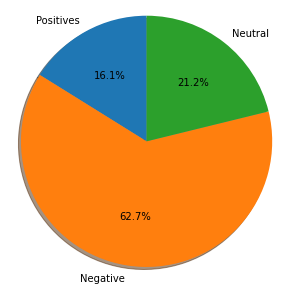

In [74]:
# Declare a figure with a custom size
fig = plt.figure(figsize=(5, 5))
# labels for the 3 classes
labels = 'Positives', 'Negative', 'Neutral'
# Sizes for each slide
sizes = [2363, 9178, 3099] 
# Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
# Display the chart
plt.show()

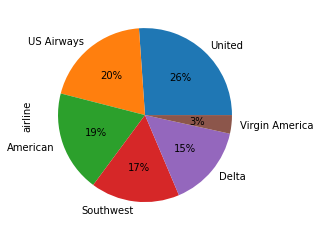

In [75]:
new_data.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

#Preprocessing

Before anything else, we can print a couple of tweets from the dataset to see how they look. Understanding the data is responsible for 80% of the success or failure in data science projects. We can use this time to observe aspects we'd like to consider when preprocessing our data.

Below, we print one random tweet. There are few things you can notice with this tweet. We can observe mentions, some special characters, the hashtag, punctuations and so on.

In [76]:
import random

print (new_data['tweets'][100])

@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM


Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:

* Tokenizing the string
* Lowercasing
* Removing stop words and punctuation
* Stemming

**Let's do it with one tweet before just to see it works**


In [77]:
tweets = new_data['tweets']
example = tweets[100]
print(example)

@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM


Cleaning the data

In [78]:
nltk.download('stopwords')                 # download the stopwords from NLTK
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

#Import the english stop words list from NLTK
stopwords_english = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###Removing hyperlinks and twitter mark styles

In [79]:
print('\033[92m' + example)
print('\033[94m')

# remove old style retweet text "RT"
tw = re.sub(r'^RT[\s]+', '', example)

# remove hyperlinks
tw = re.sub(r'https?:\/\/.*[\r\n]*', '', tw)

# remove hashtags
# only removing the hash # sign from the word
tw = re.sub(r'#', '', tw)

print(tw)

#removing mentions 
print('\033[95m')
new_tweet = re.sub(r'@[A-Za-z0-9]+','',tw)

print(new_tweet)

@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX http://t.co/GsB2J3c4gM

@VirginAmerica trying to add my boy Prince to my ressie. SF this Thursday @VirginAmerica from LAX 

 trying to add my boy Prince to my ressie. SF this Thursday  from LAX 


We've removed the url and mention in the tweet above. This is the first step  in cleaning the data

###Tokenizing

Tokenization is the process of converting a sequence of strings into a sequence of tokens (words, symbols, keywords etc)

In [80]:
print()
print('\033[92m' + new_tweet)
print('\033[94m')

# instantiate tokenizer class
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)

# tokenize tweets
tweet_tokens = tokenizer.tokenize(new_tweet)

print()
print('Tokenized string:')
print(tweet_tokens)


 trying to add my boy Prince to my ressie. SF this Thursday  from LAX 


Tokenized string:
['trying', 'to', 'add', 'my', 'boy', 'prince', 'to', 'my', 'ressie', '.', 'sf', 'this', 'thursday', 'from', 'lax']


The next step is to clean up the tokenized tweet by removing stop words. Those are the words that do not affect the sentiment of the tweet author when removed. For instance, when someone says "I am happy", removing the pronoun "I" doesn't change anything to the person emotions

###Removing stopwords and punctuations

In [81]:
tweets_clean = []

for word in tweet_tokens: # Go through every word in your tokens list
    if (word not in stopwords_english and  # remove stopwords
        word not in string.punctuation):  # remove punctuation
        tweets_clean.append(word)

print('removed stop words and punctuation:')
print(tweets_clean)

removed stop words and punctuation:
['trying', 'add', 'boy', 'prince', 'ressie', 'sf', 'thursday', 'lax']


###Stemming

I have copied an explanation from the web here (https://machinelearningmastery.com/clean-text-machine-learning-python/):

*Stemming* refers to the process of reducing each word to its root or base.

For example “fishing,” “fished,” “fisher” all reduce to the stem “fish.”

Some applications, like document classification, may benefit from stemming in order to both reduce the vocabulary and to focus on the sense or sentiment of a document rather than deeper meanin

In [82]:
# Instantiate stemming class
stemmer = PorterStemmer() 

# Create an empty list to store the stems
tweets_stem = [] 

for word in tweets_clean:
    stem_word = stemmer.stem(word)  # stemming word
    tweets_stem.append(stem_word)  # append to the list

print('stemmed words:')
print(tweets_stem)

stemmed words:
['tri', 'add', 'boy', 'princ', 'ressi', 'sf', 'thursday', 'lax']


#Preprocessing the hole dataset

Some useful functions

In [83]:
#function removing stop words and punctuations
def remove_stopwords_punctuation(tokenize_tweet):
  output = [word for word in tokenize_tweet if word not in stopwords_english and word not in string.punctuation]
  return output

#stemming function
def stem_tweet(input_tweet):
  stemmed = [stemmer.stem(word) for word in input_tweet]
  return stemmed

In [84]:
tweets = tweets.apply(lambda x: x.lower())                              #lower caseing
tweets = tweets.apply(lambda x: re.sub(r'^RT[\s]+', '', x))             #remove retweet text "RT"
tweets = tweets.apply(lambda x: re.sub(r'https?:\/\/.*[\r\n]*', '', x)) #removing hyperlinks
tweets = tweets.apply(lambda x: re.sub(r'#', '', x))                    #removing hash # sign
tweets = tweets.apply(lambda x: re.sub(r'@[A-Za-z0-9]+','',x))           #removing the mentions
tweets = tweets.apply(lambda x: tokenizer.tokenize(x))                  #tokenize tweets
tweets = tweets.apply(lambda x: remove_stopwords_punctuation(x))        #removing stopwords and punctuation
tweets = tweets.apply(lambda x: stem_tweet(x))                          #stemming

#Bag of word : Features extraction

The bag-of-words model is a way of representing text data when modeling text with machine learning algorithms. Since ML algorithms cannot work with raw text directly, the text has to be converted to vectors of numbers by building a vocabulary that allows to encode any text as an array of numbers.  

The vocabulary describes the occurences of words within tweets. 



Let's take as an example the corpus composed of 4 tweets below: \\ 

**I am ready to go** \\
**I am  happy** \\
**I went out with my friends** \\
**I am not happy today**

The vocabulary V is the list of unique words from the tweets: \\
$V = [I, am,ready,to,go,happy,went,out,with,my,friends, not, today]$ 

If a word in the vocabulary is not found in the corresponding tweet, the document feature vector will have zero in that place. \\

$tweet_1=[1,1,1,1,1,0,0,0,0,0,0,0,0]$ \\
$tweet_2=[1,1,0,0,0,1,0,0,0,0,0,0,0]$ \\
$tweet_3=[1,0,0,0,0,0,1,1,1,1,1,0,0]$ \\
$tweet_4=[1,1,0,0,0,1,0,0,0,0,0,1,1]$

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

We've got a list (tweets) so since list object has no attribute lower and we have already lowercased during the preprocessing, we set lowercase to false to prevent errors. Besides our list of tweets is already tokenized, that's the reason why we defined the function identity_tokenizer

In [86]:

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer (tokenizer=identity_tokenizer, max_features=2500, min_df=7, max_df=0.8, lowercase=False)
processed_features = vectorizer.fit_transform(tweets).toarray()

In [87]:
processed_features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.27434977, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.25936248, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#Split into training and test sets

In [88]:
labels = new_data['sentiment'] #target data

In [89]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

#Fit a linear logistic model

In [91]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression( C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###make predictions

In [92]:
y_pred = model.predict(X_test)
y_pred

array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

To evaluate the performance of the machine learning models, we can use classification metrics such as a confusion metrix, F1 measure, accuracy, etc.

In [93]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [94]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[1840   17   13]
 [ 482  109   23]
 [ 245   20  179]]
              precision    recall  f1-score   support

    negative       0.72      0.98      0.83      1870
     neutral       0.75      0.18      0.29       614
    positive       0.83      0.40      0.54       444

    accuracy                           0.73      2928
   macro avg       0.77      0.52      0.55      2928
weighted avg       0.74      0.73      0.67      2928

0.726775956284153
